In [22]:
import math
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use("seaborn-whitegrid")

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [5]:
%matplotlib inline

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
example_submission = pd.read_csv("data/gender_submission.csv")

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

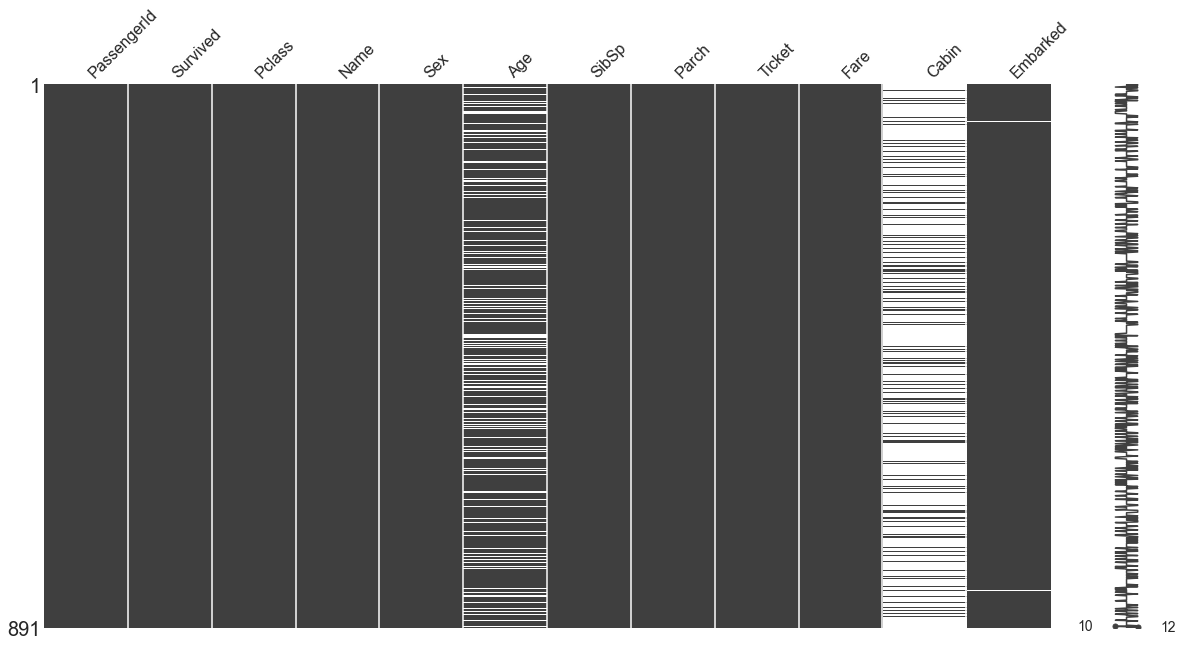

In [8]:
missingno.matrix(train, figsize=(20,10))

In [9]:
def find_missing_values(df, columns):
    missing_vals = {}
    print("Number of missing or NaN values for each column: ")
    df_length = len(df)
    for column in columns:
        total_col_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_col_values
    return missing_vals

missing = find_missing_values(train, train.columns)
print(missing)

Number of missing or NaN values for each column: 
{'PassengerId': 0, 'Survived': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 0, 'Cabin': 687, 'Embarked': 2}


In [10]:
# Create subset dataframes for different types of data
df_con = pd.DataFrame()
df_bin = pd.DataFrame()

In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# FEATURE ENGINEERING

In [12]:
# Name
# Not going to be useful for making predictions, as everyone's name is unique. However, I am going to make
# new feature by taking each persons Title and see if that helps with categorisation.
train["Title"] = train.Name.apply(lambda x: x.split(",")[1].split(".")[0].strip())

In [13]:
train.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [14]:
# Since there are a lot of values that only have a couple of entries, I think I am going to try and
# collate anything that isn't a standar Title into one category, Other.
std_titles = ["Mr", "Miss", "Mrs", "Master"]
train["Title"] = train["Title"].apply(lambda x: x if x in std_titles else "Other")

In [15]:
pd.pivot_table(train, index="Survived", columns="Title", values="Ticket", aggfunc="count")

Title,Master,Miss,Mr,Mrs,Other
Survived,,,,,
0,17,55,436,26,15
1,23,127,81,99,12


In [16]:
# Age
missing["Age"]

177

In [17]:
# So there are lot of missing values here and we can't just ignore that. My plan is to do a couple of
# things here to try and get the best results.

# Firstly, the data is unbalanced still at the moment and I want to even out the number of survivors
# vs non-survivors. Removing all of those entries that died and I don't have an age for should help.
# I will do the rest of the balance later.
len(train[(train.Age.isnull()) & (train.Survived == 0)])

125

In [18]:
to_drop = train[(train.Survived == 0) & (train.Age.isnull())]
train = train.drop(to_drop.index)

In [19]:
train.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [23]:
# Secondly, for the remaining empty Age values, I am going to impute them using the median values for
# entries with the same Title. For example, the average age of Master is a lot less than Mr.
titles = {}
median_ages = {}

for title in train.Title.unique():
    titles[title] = train[train.Title == title]
    print(f"Median {title} = {titles[title].Age.median()}")
    median_ages[title] = titles[title].Age.median()
    titles[title].Age.fillna(titles[title].Age.median(), inplace = True)
    
print(median_ages)

pickle.dump(median_ages, open("median_age.pkl", "wb"))

Median Mr = 30.0
Median Mrs = 35.0
Median Miss = 21.0
Median Master = 3.5
Median Other = 44.5
{'Mr': 30.0, 'Mrs': 35.0, 'Miss': 21.0, 'Master': 3.5, 'Other': 44.5}


In [18]:
train = titles["Mr"].append(titles["Master"]).append(titles["Miss"]).append(titles["Mrs"]).append(titles["Other"])
train = shuffle(train, random_state=23)

In [19]:
missing = find_missing_values(train, train.columns)
missing["Age"]

Number of missing or NaN values for each column: 


0

0    424
1    342
Name: Survived, dtype: int64


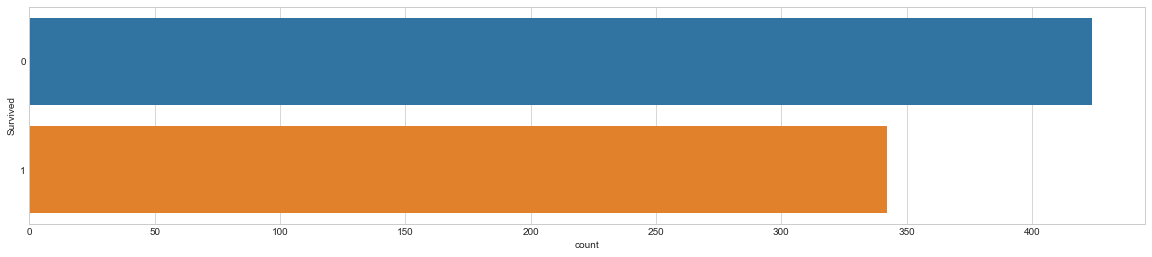

In [20]:
# Survived -- TARGET --
# How many passengers actually survived?
plt.figure(figsize=(20,4))
sns.countplot(y="Survived", data=train)
print(train.Survived.value_counts())

In [21]:
# Add the target to the subset dataframes
df_bin["Survived"] = train["Survived"]
df_con["Survived"] = train["Survived"]

In [22]:
# And now add the Title feature to the dataframes.
df_bin["Title"] = train["Title"]
df_con["Title"] = train["Title"]

# Now that I've dealt with all those missing values, I can add the Age feature to my dataframes.
# For df_bin, I will break the ages up into separate bins/categories.

df_bin["Age"] = pd.cut(train["Age"], bins=10)
df_con["Age"] = train["Age"]

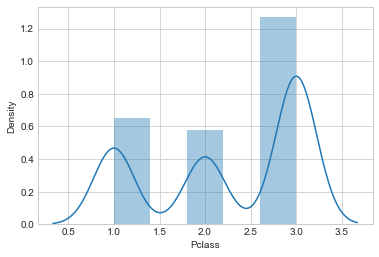

In [23]:
# Pclass
# Check the distribution of the data
sns.distplot(train.Pclass)

In [24]:
missing["Pclass"]

0

In [25]:
train.Pclass.unique()

array([2, 3, 1])

In [26]:
# No missing values and clearly categorical data, time to add them to the dataframes.
df_bin["Pclass"] = train["Pclass"]
df_con["Pclass"] = train["Pclass"]

male      469
female    297
Name: Sex, dtype: int64


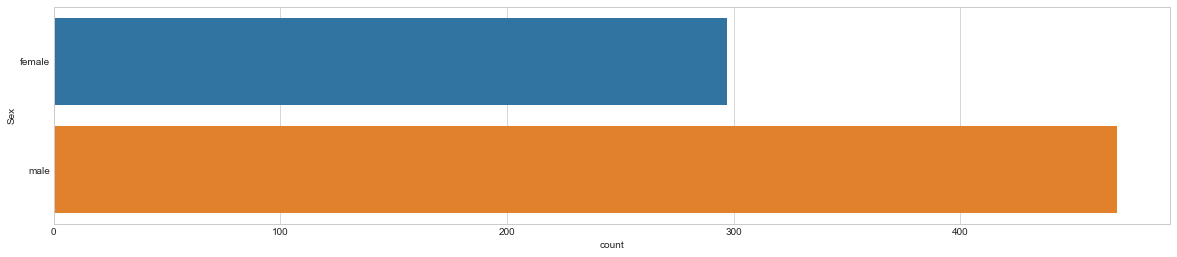

In [27]:
# Sex
plt.figure(figsize=(20,4))
sns.countplot(y="Sex", data=train)
print(train.Sex.value_counts())

In [28]:
# A pivot table to show the likelihood of surviving or not based on gender. As you can see, far more males
# died than females.
pd.pivot_table(train, index="Survived", columns="Sex", values="Ticket", aggfunc="count")

Sex,female,male
Survived,,
0,64,360
1,233,109


In [29]:
missing["Sex"]

0

In [30]:
train.Sex.unique()

array(['female', 'male'], dtype=object)

In [31]:
# Nothing missing and not much to do here other than add to the dataframes, shortcutting the need for
# OneHotEncoder on this later by doing this easy one now in the numerical df.

df_bin["Sex"] = np.where(train["Sex"] == "female", 1, 0)
df_con["Sex"] = train["Sex"]

In [32]:
# SibSp
missing["SibSp"]

0

In [33]:
train.SibSp.value_counts()

0    506
1    198
2     27
4     18
3     12
5      5
Name: SibSp, dtype: int64

In [34]:
pd.pivot_table(train, index="Survived", columns="SibSp", values="Ticket", aggfunc="count")

SibSp,0,1,2,3,4,5
Survived,,,,,,
0,296.0,86.0,14.0,8.0,15.0,5.0
1,210.0,112.0,13.0,4.0,3.0,NaN


In [35]:
df_bin["SibSp"] = train["SibSp"]
df_con["SibSp"] = train["SibSp"]

In [36]:
# Parch
missing["Parch"]

0

In [37]:
train.Parch.value_counts()

0    568
1    114
2     69
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [38]:
pd.pivot_table(train, index="Survived", columns="Parch", values="Ticket", aggfunc="count")

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,335.0,49.0,29.0,2.0,4.0,4.0,1.0
1,233.0,65.0,40.0,3.0,NaN,1.0,NaN


In [39]:
df_bin["Parch"] = train["Parch"]
df_con["Parch"] = train["Parch"]

In [40]:
# Ticket
missing["Ticket"]

0

In [41]:
# Way too many different ticket numbers and while there may be some way to categorise them, I'd be 
# guessing and might not be accurate, so I think I will leave this out
train.Ticket.value_counts()

347082               7
3101295              6
CA 2144              6
347088               6
1601                 6
                    ..
W/C 14208            1
STON/O 2. 3101286    1
2685                 1
2672                 1
3101277              1
Name: Ticket, Length: 580, dtype: int64

In [42]:
# Fare

# No missing entries but some equal to 0, so since there are only a couple, we can remove them.
print(f"Missing entries: {missing['Fare']}")
to_drop = train[train.Fare == 0]
print(f"Entries equal to 0: {len(to_drop)}")
train = train.drop(to_drop.index)
df_bin = df_bin.drop(to_drop.index)
df_con = df_con.drop(to_drop.index)

Missing entries: 0
Entries equal to 0: 7


In [43]:
# Also a lot of different values for Fare, but this is continuous so I will be using it.
train.Fare.value_counts()

13.0000    42
26.0000    30
8.0500     29
10.5000    24
7.8958     23
           ..
8.1125      1
15.0458     1
39.4000     1
40.1250     1
8.1583      1
Name: Fare, Length: 226, dtype: int64

In [44]:
# Just to try and slightly normalise the distribution here, I am going to use the log Fare prices rather
# than use them in their raw form.

train["Fare"] = train["Fare"].apply(lambda x: np.log(x))

In [45]:
# And for the df_bin I am going to split them up into some more equal bins using the qcut method.

df_bin["Fare"] = pd.qcut(train["Fare"], 5)
df_con["Fare"] = train["Fare"]

In [46]:
# Cabin
missing["Cabin"]

570

In [47]:
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
E101           3
              ..
B19            1
A5             1
E38            1
C46            1
D6             1
Name: Cabin, Length: 138, dtype: int64

In [48]:
# Too many different cabins to be useful for categorisation, but maybe cabins with the same letters were
# in similar places so I am going to just use the initial letter, and have all the missing values be a 
# category in and of itself.

train.Cabin = train.Cabin.apply(lambda x: str(x)[0])

In [49]:
train.Cabin.value_counts()

n    565
C     56
B     45
D     33
E     32
F     12
A     11
G      4
T      1
Name: Cabin, dtype: int64

In [50]:
# It looks like there is more chance of survival if the entry has a Cabin of any sort except perhaps A.

pd.pivot_table(train, index="Survived", columns="Cabin", values="Ticket", aggfunc="count")

Cabin,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,4.0,10.0,21.0,8.0,8.0,4.0,2.0,1.0,360.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,205.0


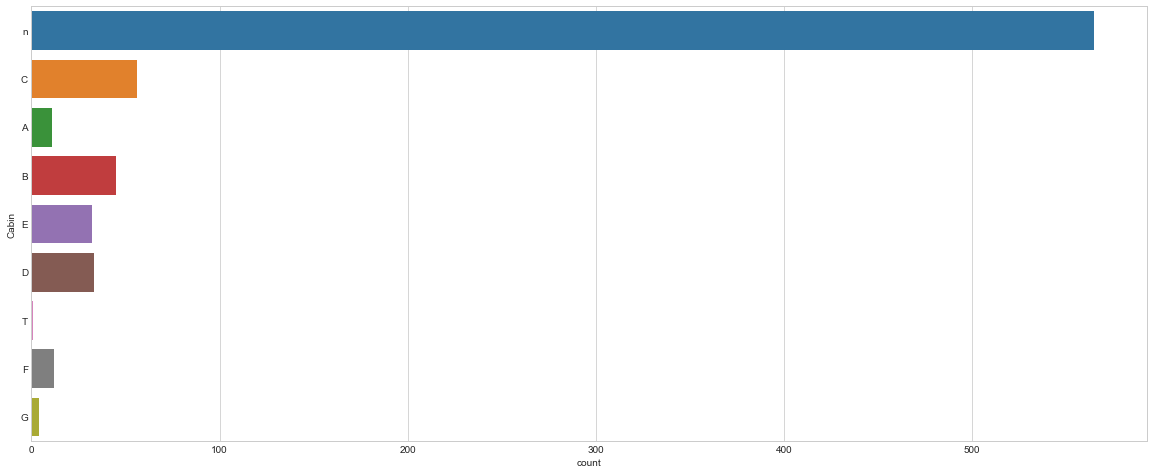

In [51]:
plt.figure(figsize=(20,8))
sns.countplot(y="Cabin", data=train)

In [52]:
df_bin["Cabin"] = train["Cabin"]
df_con["Cabin"] = train["Cabin"]

In [53]:
# Embarked

# Only 2 missing entries, might just drop them, first though I will see if its relevant info that I'm
# going to include.

missing["Embarked"]

2

In [54]:
train.Embarked.unique()

array(['S', 'C', nan, 'Q'], dtype=object)

In [55]:
# It looks like there is a difference here and you perhaps are more likely to survive if you didn't board
# at Southampton.

pd.pivot_table(train, index="Survived", columns="Embarked", values="Ticket", aggfunc="count")

Embarked,C,Q,S
Survived,,,
0,51,20,347
1,93,30,216


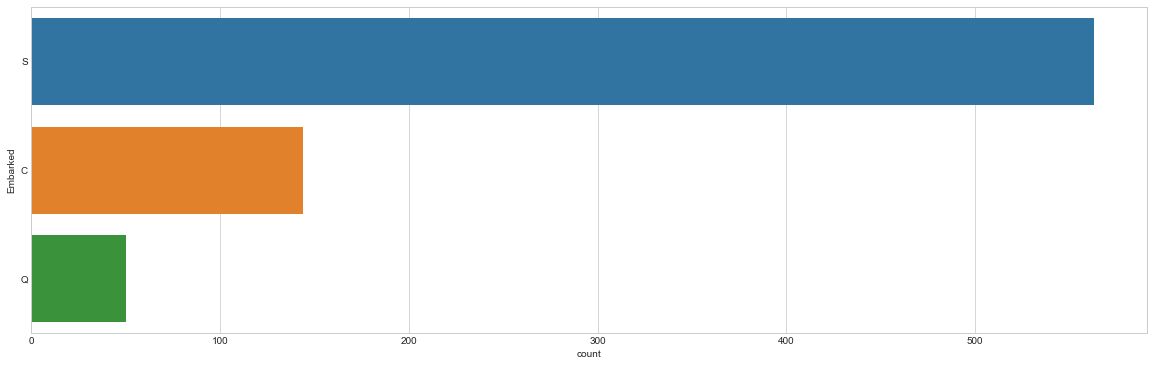

In [56]:
plt.figure(figsize=(20,6))
sns.countplot(y="Embarked", data=train)

In [57]:
df_bin["Embarked"] = train["Embarked"]
df_con["Embarked"] = train["Embarked"]

In [58]:
train.dropna(inplace=True)
df_bin.dropna(inplace=True)
df_con.dropna(inplace=True)

In [59]:
# Balancing the data
train.Survived.value_counts()

0    418
1    339
Name: Survived, dtype: int64

In [60]:
def under_sample(df, target):
    count_0, count_1 = df[target].value_counts()
    df_0 = df[df[target] == 0]
    df_1 = df[df[target] == 1]
    if len(df_0) > len(df_1):
        under_sample = df_0.sample(count_1, random_state=23)
        df = pd.concat([under_sample, df_1])
    else:
        under_sample = df_1.sample(count_0, random_state=23)
        df = pd.concat([under_sample, df_0])
    return df
    

In [61]:
train = shuffle(under_sample(train, "Survived"), random_state=23)
df_bin = shuffle(under_sample(df_bin, "Survived"), random_state=23)
df_con = shuffle(under_sample(df_con, "Survived"), random_state=23)

In [62]:
train.Survived.value_counts()

1    339
0    339
Name: Survived, dtype: int64

In [63]:
scaler = MinMaxScaler()
df_con[["Age", "Fare", "SibSp", "Parch"]] = scaler.fit_transform(df_con[["Age", "Fare", "SibSp", "Parch"]])

In [64]:
df_con.head()

,Survived,Title,Age,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked
239,0,Mr,0.409399,2,male,0.0,0.000000,0.230568,n,S
805,0,Mr,0.384267,3,male,0.0,0.000000,0.136404,n,S
237,1,Miss,0.095250,2,female,0.0,0.333333,0.387304,n,S
153,0,Mr,0.503644,3,male,0.0,0.333333,0.264918,n,S
294,0,Mr,0.296306,3,male,0.0,0.000000,0.139583,n,S


In [65]:
one_hot_cols = ["Title", "Pclass", "Sex", "Cabin", "Embarked"]
train_con = pd.get_dummies(df_con, columns = one_hot_cols)

In [66]:
train_con.head()

,Survived,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_n,Embarked_C,Embarked_Q,Embarked_S
239,0,0.409399,0.0,0.000000,0.230568,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
805,0,0.384267,0.0,0.000000,0.136404,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
237,1,0.095250,0.0,0.333333,0.387304,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
153,0,0.503644,0.0,0.333333,0.264918,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
294,0,0.296306,0.0,0.000000,0.139583,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [69]:
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove("Survived")
train_bin = pd.get_dummies(df_bin, columns = one_hot_cols)

In [70]:
train_bin.head()

,Survived,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,"Age_(0.34, 8.378]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]",...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_n,Embarked_C,Embarked_Q,Embarked_S
239,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
805,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
237,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
153,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
294,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [74]:
train_con.to_csv("train_con.csv", index=False)
train_bin.to_csv("train_bin.csv", index=False)